# Problem 4 - Off-policy Monte Carlo with Importance Sampling
Implement the off-policy Monte Carlo method with importance sampling to estimate the value function for the 5x5 Gridworld environment defined in Problem 3.

## Set the lec3_DP Python module path
Use the environment setup code in the lec3_DP folder with custom Monte Carlo and Importance Sampling workflows.

In [25]:
import sys
import os

# Find lec3_DP path
sys.path.append(os.path.join(os.getcwd(), 'playground', 'lec3_DP'))
print("Path setup complete. Ready for imports.")

Path setup complete. Ready for imports.


## Importing GridWorld and Agent classes

In [26]:
import numpy as np
from gridworld import GridWorld
from value_iteration_agent import Agent

## Initialize a 5x5 Gridworld environment and set the reward
- End State: (4,4) Reward +10
- Gray State: \{(2,2), (3,0), (0,4)\} Penalty -5
- Other States: Penalty -1

In [27]:
# Initialize a 5x5 Gridworld environment
env = GridWorld(5)

# Adjust reward: +10 for the end point, -5 for the gray grid, -1 for the rest
env.reward = np.ones((env.env_size, env.env_size)) * -1
grey_states = [(2, 2), (3, 0), (0, 4)]
for gs in grey_states:
    env.reward[gs] = -5
env.reward[env.terminal_state] = 10

print("Adjusted reward matrix:\n", env.reward)

Adjusted reward matrix:
 [[-1. -1. -1. -1. -5.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -5. -1. -1.]
 [-5. -1. -1. -1. -1.]
 [-1. -1. -1. -1. 10.]]


## Define the behavior policy (random policy) and target policy (greedy policy)

### Policy Definitions
- Behavior policy $b(a|s)$: Uniformly random action selection with probability $1/4$.
- Target policy $pi(a|s)$: Greedy policy derived from Value Iteration.

### Discount factor
The discount factor is set as: $gamma = 0.9$

Which controls the relative importance of future rewards versus immediate rewards.

In [28]:
import random

gamma = 0.9

# Behavior policy: uniformly random action selection
def behavior_policy(state):
    return random.choice(range(len(env.get_actions())))

# The initial target strategy is defined as the result of Value Iteration. Run Value Iteration once to get the strategy.
agent = Agent(env, theta_threshold=0.01, gamma=gamma)
MAX_ITER = 1000
for _ in range(MAX_ITER):
    new_V = np.copy(agent.get_value_function())
    for i in range(env.env_size):
        for j in range(env.env_size):
            if not env.is_terminal_state(i,j):
                new_V[i,j], _, _ = agent.calculate_max_value(i,j)
    if agent.is_done(new_V):
        agent.update_value_function(new_V)
        break
    agent.update_value_function(new_V)
agent.update_greedy_policy()
target_policy = agent.get_policy()

## Generate an episode

In [29]:
def generate_episode(env, behavior_policy, max_steps=100):
    episode = []
    i, j = 0, 0 # Assume the initial state starts from (0, 0)
    step = 0
    while step < max_steps and not env.is_terminal_state(i, j):
        action = behavior_policy((i,j))
        next_i, next_j, reward, done = env.step(action, i, j)
        episode.append(((i, j), action, reward))
        i, j = next_i, next_j
        if done:
            break
        step += 1
    return episode

## Off-policy Monte Carlo with Importance Sampling to estimate the Value Function

### Discounted cumulative return calculation
In each episode, the discounted cumulative return is calculated from the end to the beginning.

The discounted return $G_t$ at each time step $t$ in an episode is defined as:

$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{k=t+1}^T \gamma^{k-(t+1)} R_k$


### State Value Function $V(s)$ Update

The weighted Monte Carlo estimate updates the state value function as:

$C(s_t) \leftarrow C(s_t) + W_t$

$V(s_t) \leftarrow V(s_t) + \frac{W_t}{C(s_t)} \bigl( G_t - V(s_t) \bigr)$


### Importance Sampling Weight Calculation

Since data is generated under a behavior policy $b(a|s)$ but we want to estimate values under a target policy $pi(a|s)$, importance sampling weights are used:

$W_t = \prod_{k=t}^T \frac{\pi(a_k | s_k)}{b(a_k | s_k)}$


### Convergence Criterion

The algorithm checks convergence by computing the maximum absolute difference between the Monte Carlo estimated value function and the Value Iteration value function every 1000 episodes:

$max_s | V_{MC}(s) - V_{VI}(s) | < \epsilon$

where $epsilon = 0.01$

In [30]:
num_episodes = 10000

# Initialize the Value function and weights
V = np.zeros((env.env_size, env.env_size))
C = np.zeros((env.env_size, env.env_size))

for ep in range(num_episodes):
    episode = generate_episode(env, behavior_policy)
    G = 0
    W = 1
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        i, j = state
        G = gamma * G + reward

        # For each step, use Importance Sampling to adjust
        C[i, j] += W
        V[i, j] += (W / C[i, j]) * (G - V[i, j])

        # Weight update is determined based on the target strategy
        # Here assume the target strategy is greedy: b(a|s) is the behavior strategy prob (uniform random 1/4)
        # Because the target strategy is to determine the action, prob is 1 or 0
        target_action = target_policy[i, j]
        if action != target_action:
            break
        W = W * 1.0 / (1.0 / len(env.get_actions()))  # The probability of the behavioral strategy is uniformly one-quarter
    
    # Convergence judgment avoids unnecessary iterations
    if ep % 1000 == 0:
        max_delta = np.max(np.abs(V - agent.get_value_function()))
        if max_delta < 0.01:
            print(f"Converged after {ep} episodes with max delta {max_delta:.4f}")
            break

## Comparing Value Iteration results

In [31]:
# Display the estimated Value function
print("\nEstimated Value Function by Off-policy Monte Carlo with Importance Sampling:")
print(np.round(V, 2))

print("\nComparing to Value Iteration value function:")
print(np.round(agent.get_value_function(),2))


Estimated Value Function by Off-policy Monte Carlo with Importance Sampling:
[[-0.89  0.18  0.82  0.87  1.12]
 [ 0.53  1.63  0.86  3.11  3.23]
 [-0.3   0.7   3.29  4.01  5.65]
 [ 1.48  1.53  4.    6.23  7.52]
 [ 2.38  4.1   5.84  7.5   0.  ]]

Comparing to Value Iteration value function:
[[-0.43  0.63  1.81  3.12  4.58]
 [ 0.63  1.81  3.12  4.58  6.2 ]
 [ 1.81  3.12  4.58  6.2   8.  ]
 [ 3.12  4.58  6.2   8.   10.  ]
 [ 4.58  6.2   8.   10.    0.  ]]


- Overview of Result Differences

    | Method | Value Function Characteristics |
    |------------------------------------------|----------------------------------------------------|
    | Off-policy Monte Carlo with Importance Sampling | The values ​​are generally lower and more volatile than those estimated by Value Iteration |
    | Value Iteration | Smoother, significantly larger values, closer to the theoretical optimal solution (e.g., the endpoint value is indeed large) |

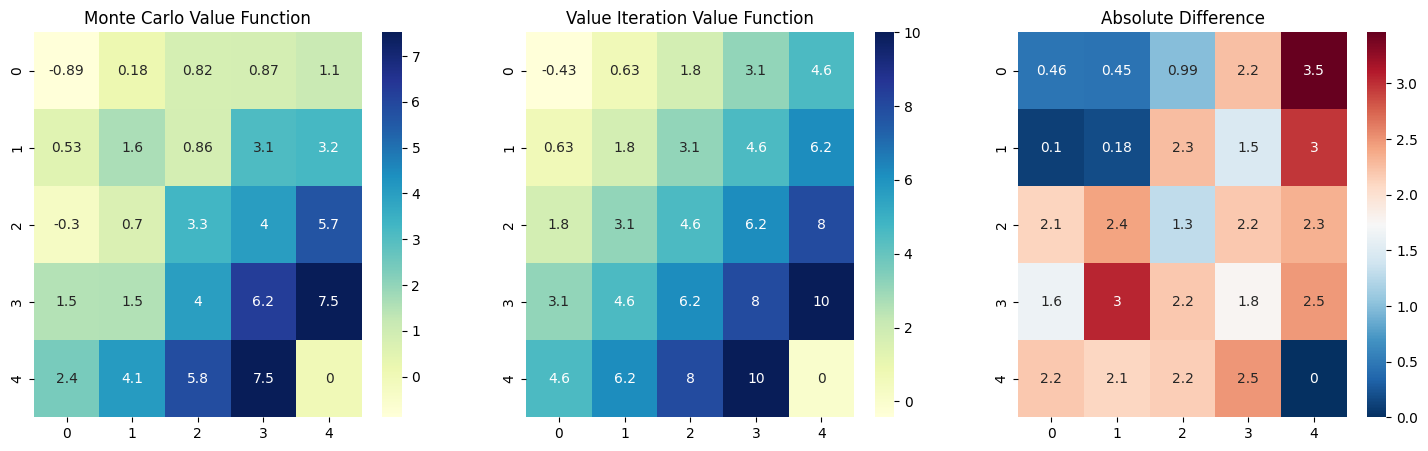

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define V_mc and V_vi
V_mc = np.round(V, 2)
V_vi = np.round(agent.get_value_function(),2)

# Assume V_mc and V_vi are the Value Function matrices of Monte Carlo and Value Iteration
def plot_value_heatmaps(V_mc, V_vi):

    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    sns.heatmap(V_mc, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Monte Carlo Value Function")

    plt.subplot(1,3,2)
    sns.heatmap(V_vi, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Value Iteration Value Function")

    plt.subplot(1,3,3)
    diff = np.abs(V_mc - V_vi)
    sns.heatmap(diff, annot=True, cmap="RdBu_r", cbar=True)
    plt.title("Absolute Difference")

    plt.show()

# Plot the heatmaps
plot_value_heatmaps(V_mc, V_vi)


- Summary
    - Value Iteration provides a more accurate and smoother value function.
    - Off-policy Monte Carlo estimation can produce results, but the estimation error is large and unstable.
    - The difference between the two methods stems primarily from the limited sample size and large fluctuations in importance sampling weights in Monte Carlo.
    - Validating and improving Monte Carlo methods (by expanding the sample size and updating the policy) can improve estimation quality.